**Deep computer vision**

In [1]:
%tensorflow_version 2.x

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
#LOAD AND SPLIT DATASET
(train_images, train_labels),(test_images, test_labels) = datasets.cifar10.load_data()


#Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0 , test_images / 255.0

class_names = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']


170500096/170498071 [==============================] - 4s 0us/step


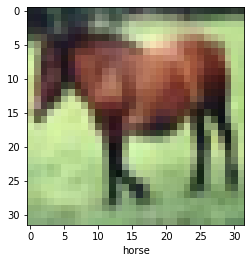

In [3]:
#Let's look at a one image

IMG_INDEX = 7  #choose any random image

plt.imshow(train_images[IMG_INDEX], cmap = plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.show()



In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu',input_shape=(32,32,3)))#conv layer with filters no. 32 of size 3x3
model.add(layers.MaxPooling2D((2,2))) # dimentionality reduction
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))  # rest of the layers do the same but with the outcome of the previous layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


After looking at the summary you should notice that the depth of our image increases but the spacial dimensions reduce drastically

In [5]:
# Now we need to take these extracted features and add a way to classify them

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )
history = model.fit(train_images, train_labels, epochs=4,
                    validation_data=(test_images,test_labels))

Epoch 1/4
1563/1563 [==============================] - 72s 46ms/step - loss: 1.7737 - accuracy: 0.3433 - val_loss: 1.2537 - val_accuracy: 0.5476
Epoch 2/4
1563/1563 [==============================] - 70s 45ms/step - loss: 1.2036 - accuracy: 0.5720 - val_loss: 1.0828 - val_accuracy: 0.6209
Epoch 3/4
1563/1563 [==============================] - 71s 45ms/step - loss: 1.0239 - accuracy: 0.6404 - val_loss: 0.9846 - val_accuracy: 0.6540
Epoch 4/4
1563/1563 [==============================] - 71s 46ms/step - loss: 0.9193 - accuracy: 0.6761 - val_loss: 0.9520 - val_accuracy: 0.6672


In [7]:
#Evaluating the Model

test_loss, test_acc = model.evaluate(test_images,test_labels, verbose=2)
print(test_acc)

313/313 - 4s - loss: 0.9520 - accuracy: 0.6672
0.6672000288963318


**Data Augmentation**

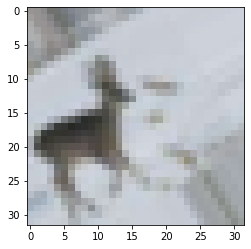

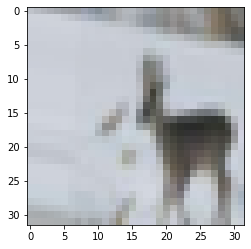

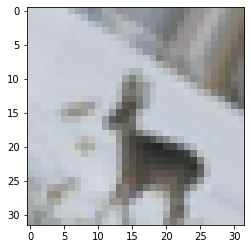

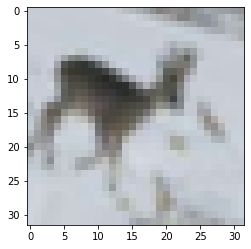

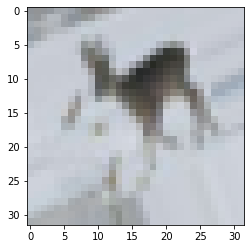

In [8]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

#creates a data generator object that transforms images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#pick an image to transform
test_img = train_images[20]
img = image.img_to_array(test_img)# convert to numpy array
img = img.reshape((1,)+img.shape) #reshape image

i = 0

for batch in datagen.flow(img, save_prefix='test', save_format='jpeg'):
  plt.figure(i)
  plot=plt.imshow(image.img_to_array(batch[0]))
  i+=1
  if(i>4):
    break

plt.show()

**Using a pretrained Model**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [9]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [ ]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [ ]:
# Training the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)

model.save("dogs_vs_cats.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('dogs_vs_cats.h5')